# Part One

In [1]:
import cv2
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
image_path = ['Q1/Cameraman.png', 'Q1/Sinusoidal-Synthetic.png']
image = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_path]

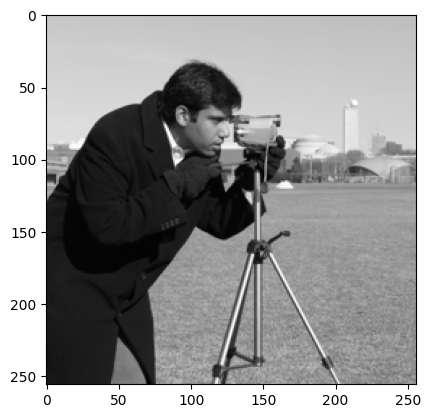

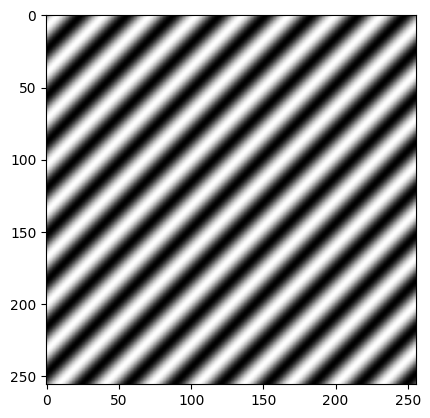

In [3]:
for img in image:
    plt.imshow(img, cmap = 'gray')
    plt.show()

In [4]:
for index, img in enumerate(image):
    print('Cameraman :' if index == 0 else 'Sinusoidal Synthetic')
    print(img.ndim)
    print(img.shape)
    print(img.size)
    print('\n\n')

Cameraman :
2
(256, 256)
65536



Sinusoidal Synthetic
2
(256, 256)
65536





In [5]:
def Bit_Plane(image):
    bit_plane =[]
    for i in range(8):
        bit_plane.append((image >> i) & 1)
    return bit_plane

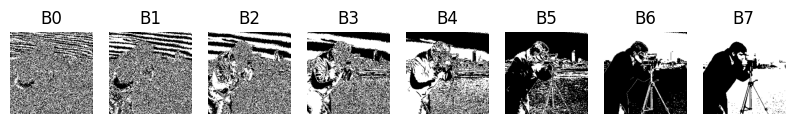

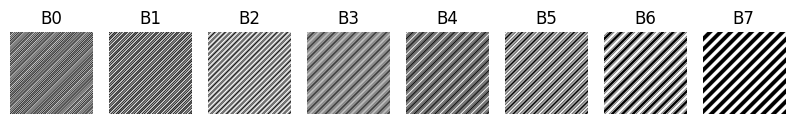

In [6]:
for index, img in enumerate(image):
    plt.figure(figsize=(10, 3))
    B = Bit_Plane(img)
    for i in range(8):
        plt.subplot(1, 8, i + 1)
        plt.title(f'B{i}')
        plt.imshow(B[i], cmap = 'gray')
        plt.axis('off')
    plt.show()

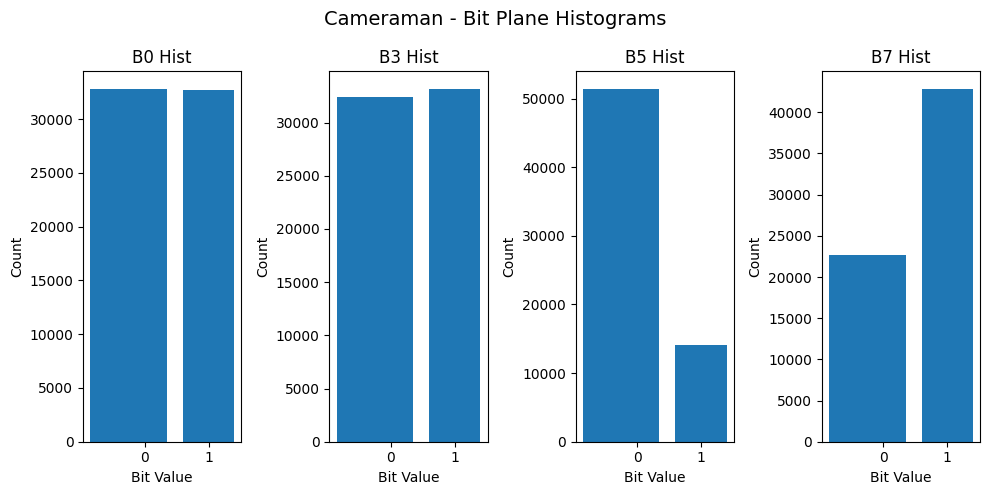

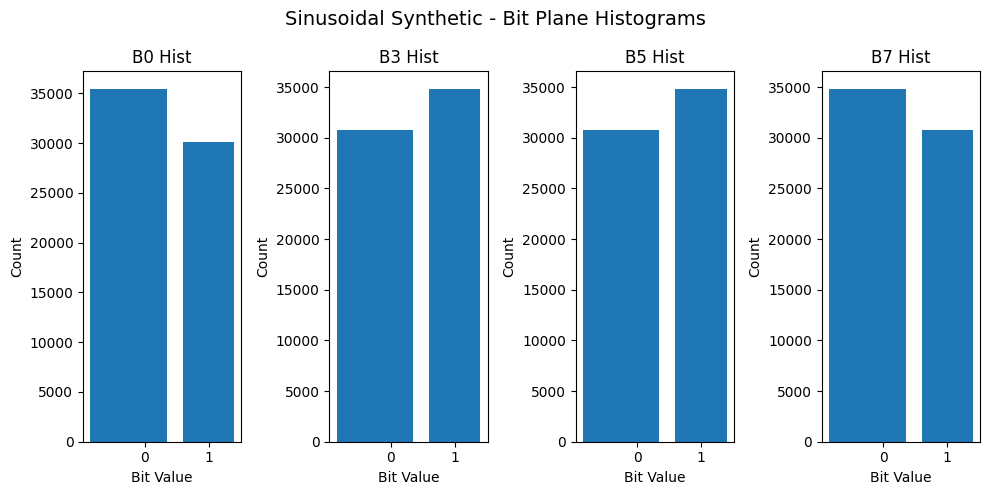

In [7]:
for index, img in enumerate(image):
    B = Bit_Plane(img)
    plt.figure(figsize=(10, 5))
    for ind, i in enumerate([0, 3, 5, 7]):
        plt.subplot(1, 4, ind + 1)
        plt.hist(B[i].ravel(), bins=[-1, 0.5, 1.5], rwidth=0.8)
        # Flatten the 2D bit-plane array into 1D for histogram
        
        plt.xlabel('Bit Value')
        plt.title(f'B{i} Hist')
        plt.ylabel('Count')
    plt.suptitle(f"{'Cameraman' if index == 0 else 'Sinusoidal Synthetic'} - Bit Plane Histograms",fontsize=14)
    plt.tight_layout()
    plt.show()

# Part Two

In [8]:
def reconstruct_image(image, bits):
    B = Bit_Plane(image)
    recon = np.zeros_like(image, dtype=np.uint16)
    for i in bits:
        recon += B[i] << i
    return np.uint8(np.clip(recon, 0, 255))

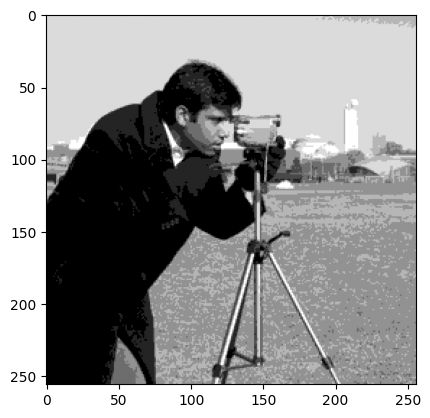

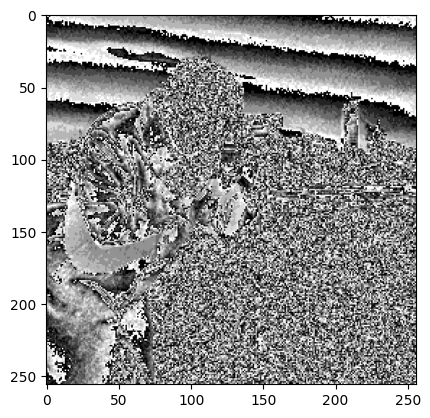

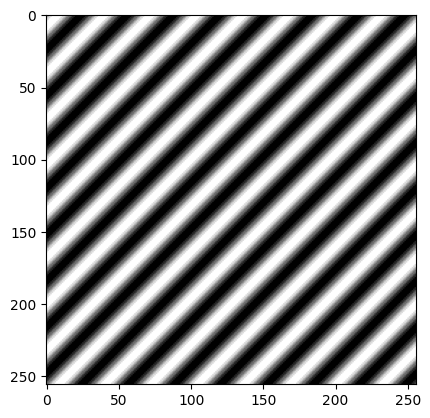

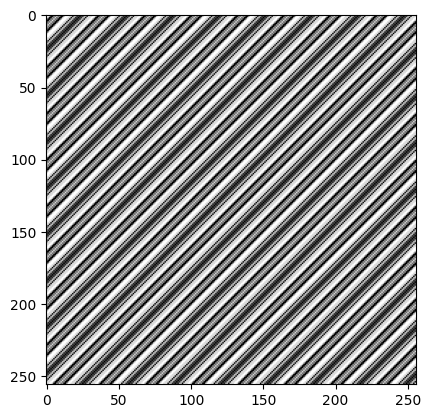

In [9]:
plt.imshow(reconstruct_image(image[0], [7,6,5]), cmap='gray')
plt.show()
plt.imshow(reconstruct_image(image[0], [0,1,2]), cmap = 'gray')
plt.show()
plt.imshow(reconstruct_image(image[1], [7,6,5]), cmap = 'gray')
plt.show()
plt.imshow(reconstruct_image(image[1], [0,1,2]), cmap = 'gray')
plt.show()

In [10]:
def MSE(image1, image2):

    return np.mean((image1.astype(np.float32) - image2.astype(np.float32)) ** 2)
   

In [11]:
def PSNR(mse_value):
    if mse_value == 0:
        return float('inf')
    return 20 * math.log10(255 / math.sqrt(mse_value))


In [12]:
def Entropy(image):
    hist, _ = np.histogram(image, bins=256, range=(0, 255))
    p = hist / np.sum(hist)
    p = p[p > 0]
    H = -np.sum(p * np.log2(p))

    return H


In [13]:
def results(image):
    for index, img in enumerate(image):
        results = []
        for k in range(1, 9):
            bits = list(range(8 - k, 8))
            recon = reconstruct_image(img, bits)
            mse = MSE(img, recon)
            psnr = PSNR(mse)
            H = Entropy(recon)
            results.append([k, mse, psnr, H])

        print(f"\nResults for {'Cameraman' if index == 0 else 'Sinusoidal Synthetic'}:")
        print("k\tMSE\t\tPSNR\tEntropy")
        for r in results:
            print(f"{r[0]}\t{r[1]:.4f}\t{r[2]:.2f}\t{r[3]:.2f}")


In [14]:
results(image)


Results for Cameraman:
k	MSE		PSNR	Entropy
1	2938.4214	13.45	0.93
2	710.1321	19.62	1.80
3	348.0726	22.71	2.46
4	78.4662	29.18	3.31
5	17.7899	35.63	4.21
6	3.4388	42.77	5.16
7	0.4995	51.15	6.14
8	0.0000	inf	7.13

Results for Sinusoidal Synthetic:
k	MSE		PSNR	Entropy
1	6254.0059	10.17	1.00
2	1475.2518	16.44	1.89
3	329.8749	22.95	2.83
4	81.1864	29.04	3.59
5	20.8422	34.94	3.89
6	3.1701	43.12	3.98
7	0.4590	51.51	4.06
8	0.0000	inf	4.12


In [15]:
def flip_bits(bit_plane, flip_ratio=0.15):
    """Flip a percentage of pixels in the bit-plane"""
    flat = bit_plane.ravel()
    indices = np.random.choice(flat.size, int(flat.size * flip_ratio), replace=False)
    flat[indices] = 1 - flat[indices]
    return flat.reshape(bit_plane.shape)

In [16]:
def reconstruct_image_from_bitplanes(bit_planes, bits):
    recon = np.zeros_like(bit_planes[0], dtype=np.uint16)
    for i in bits:
        recon += bit_planes[i] << i
    return np.uint8(np.clip(recon, 0, 255))

In [17]:
def results_with_flip(images):
    for index, img in enumerate(images):
        results = []
        psnr_flip_all = []
        entropy_flip_all = []

        for k in range(1, 9):
            bits = list(range(8 - k, 8))
            recon = reconstruct_image(img, bits)
            mse = MSE(img, recon)
            psnr = PSNR(mse)
            H = Entropy(recon)
            results.append([k, mse, psnr, H])

            B = Bit_Plane(img)
            B_flipped = B.copy()
            for i in bits:
                B_flipped[i] = flip_bits(B[i], 0.15)
            recon_flipped = reconstruct_image_from_bitplanes(B_flipped, bits)
            mse_flipped = MSE(img, recon_flipped)
            psnr_flip_all.append(PSNR(mse_flipped))
            entropy_flip_all.append(Entropy(recon_flipped))

        print(f"\nResults for {'Cameraman' if index == 0 else 'Sinusoidal Synthetic'}:")
        print("k\tMSE\t\tPSNR\tEntropy\tPSNR_flip\tEntropy_flip")
        for r, pf, ef in zip(results, psnr_flip_all, entropy_flip_all):
            print(f"{r[0]}\t{r[1]:.4f}\t{r[2]:.2f}\t{r[3]:.2f}\t{pf:.2f}\t\t{ef:.2f}")

        k_values = range(1, 9)
        plt.figure(figsize=(12,5))

        plt.subplot(1,2,1)
        plt.plot(k_values, [r[2] for r in results], marker='o', label='Original PSNR')
        plt.plot(k_values, psnr_flip_all, marker='x', label='PSNR after flip')
        plt.xlabel('Number of Bits (k)')
        plt.ylabel('PSNR (dB)')
        plt.title('PSNR vs k')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(k_values, [r[3] for r in results], marker='o', label='Original Entropy')
        plt.plot(k_values, entropy_flip_all, marker='x', label='Entropy after flip')
        plt.xlabel('Number of Bits (k)')
        plt.ylabel('Entropy')
        plt.title('Entropy vs k')
        plt.legend()

        plt.tight_layout()
        plt.show()



Results for Cameraman:
k	MSE		PSNR	Entropy	PSNR_flip	Entropy_flip
1	2938.4214	13.45	0.93	10.23		0.97
2	710.1321	19.62	1.80	12.31		1.92
3	348.0726	22.71	2.46	12.71		2.80
4	78.4662	29.18	3.31	12.91		3.77
5	17.7899	35.63	4.21	12.96		4.75
6	3.4388	42.77	5.16	12.98		5.75
7	0.4995	51.15	6.14	12.98		6.74
8	0.0000	inf	7.13	13.00		7.74


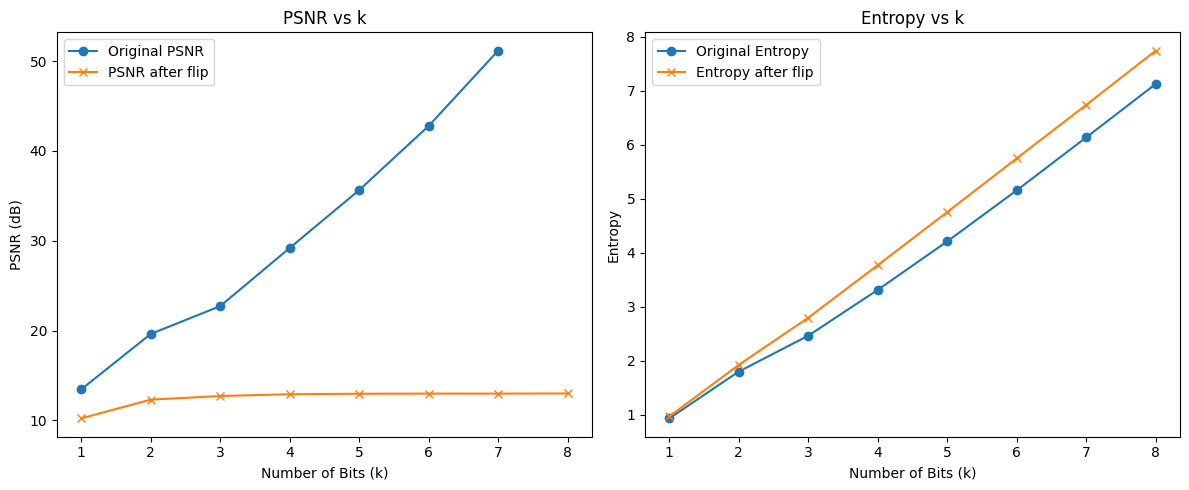


Results for Sinusoidal Synthetic:
k	MSE		PSNR	Entropy	PSNR_flip	Entropy_flip
1	6254.0059	10.17	1.00	8.50		1.00
2	1475.2518	16.44	1.89	11.18		1.97
3	329.8749	22.95	2.83	12.25		2.96
4	81.1864	29.04	3.59	12.54		3.94
5	20.8422	34.94	3.89	12.66		4.88
6	3.1701	43.12	3.98	12.67		5.77
7	0.4590	51.51	4.06	12.69		6.66
8	0.0000	inf	4.12	12.67		7.50


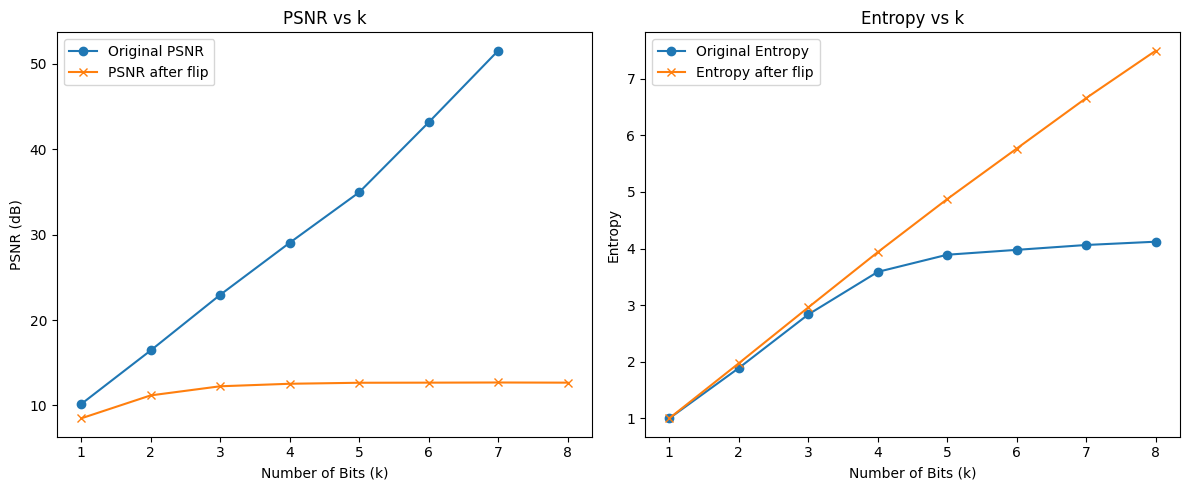

In [18]:
results_with_flip(image)
